In [29]:
import pandas as pd
import pandana, time, os, pandas as pd, numpy as np
from pandana.loaders import osm
from shapely.geometry import Polygon

# Create Pandana network and calculate distances

In [3]:
# configure search at a max distance of 1 km for up to the 10 nearest points-of-interest
amenities = ['restaurant', 'bar', 'school', 'toilets', 'college', 'hospital']#, 'hospital']
distance = 1000
num_pois = 10
num_categories = len(amenities) + 1 #one for each amenity, plus one extra for all of them combined

# bounding box as a list of llcrnrlat, llcrnrlng, urcrnrlat, urcrnrlng
bbox = [55.6036813, 12.5202081, 55.6942218, 12.6150132]#[55.5036813, 12.4202081, 55.7442218, 12.6750132]

# configure filenames to save/load POI and network datasets
bbox_string = '_'.join([str(x) for x in bbox])
net_filename = 'data/network_{}.h5'.format(bbox_string)
poi_filename = 'data/pois_{}_{}.csv'.format('_'.join(amenities), bbox_string)


## download pois and network nodes

In [4]:

start_time = time.time()
if os.path.isfile(poi_filename):
    # if a points-of-interest file already exists, just load the dataset from that
    pois = pd.read_csv(poi_filename)
    method = 'loaded from CSV'
else:   
    # otherwise, query the OSM API for the specified amenities within the bounding box 
    osm_tags = '"amenity"~"{}"'.format('|'.join(amenities))
    pois = osm.node_query(lat_min=bbox[0],lng_min=bbox[1], lat_max=bbox[2], lng_max=bbox[3], tags=osm_tags)
    
    # using the '"amenity"~"school"' returns preschools etc, so drop any that aren't just 'school' then save to CSV
    pois = pois[pois['amenity'].isin(amenities)]
    pois.to_csv(poi_filename, index=False, encoding='utf-8')
    method = 'downloaded from OSM'
    
print('{:,} POIs {} in {:,.2f} seconds'.format(len(pois), method, time.time()-start_time))
pois[['amenity', 'name', 'lat', 'lon']].head()


start_time = time.time()
if os.path.isfile(net_filename):
    # if a street network file already exists, just load the dataset from that
    network = pandana.network.Network.from_hdf5(net_filename)
    method = 'loaded from HDF5' 
else:
    #otherwise, query the OSM API for the street network within the specified bounding box
    network = osm.pdna_network_from_bbox(lat_min=bbox[0],lng_min=bbox[1], lat_max=bbox[2], lng_max=bbox[3])
    method = 'downloaded from OSM'

    # identify nodes that are connected to fewer than some threshold of other nodes within a given distance
    lcn = network.low_connectivity_nodes(impedance=1000, count=10, imp_name='distance')
    network.save_hdf5(net_filename, rm_nodes=lcn) #remove low-connectivity nodes and save to h5

print('Network with {:,} nodes {} in {:,.2f} secs'.format(len(network.node_ids), method, time.time()-start_time))

1,101 POIs loaded from CSV in 0.05 seconds
Network with 21,106 nodes loaded from HDF5 in 1.52 secs


## compute network and create df

In [5]:
network.precompute(distance + 1)
# initialize the underlying C++ points-of-interest engine
network.init_pois(num_categories=num_categories, max_dist=distance, max_pois=num_pois)
# initialize a category for all amenities with the locations specified by the lon and lat columns
network.set_pois(category='all', x_col=pois['lon'], y_col=pois['lat'])
# initialize each amenity category with the locations specified by the lon and lat columns
for amenity in amenities:
    pois_subset = pois[pois['amenity']==amenity]
    network.set_pois(category=amenity, x_col=pois_subset['lon'], y_col=pois_subset['lat'])


temp_df = network.nodes_df

for ame in amenities:
    temp_df[f'{ame}_distance'] = network.nearest_pois(distance=distance, category=f'{ame}', num_pois=num_pois)[1]


Reading parameters from init_pois()
Reading parameters from init_pois()
Reading parameters from init_pois()
Reading parameters from init_pois()
Reading parameters from init_pois()
Reading parameters from init_pois()
Reading parameters from init_pois()
Reading parameters from init_pois()
Reading parameters from init_pois()
Reading parameters from init_pois()
Reading parameters from init_pois()
Reading parameters from init_pois()
Reading parameters from init_pois()
Reading parameters from init_pois()


In [6]:
temp_df

x          y  restaurant_distance  bar_distance  \
id                                                                    
118725      12.562906  55.673985            95.097000    130.087997   
118744      12.560034  55.661718           213.123001    639.276001   
118759      12.553866  55.657275           859.354004    550.807007   
118763      12.542231  55.654003           246.557999    246.557999   
118764      12.542389  55.653946           258.287994    258.287994   
...               ...        ...                  ...           ...   
9087861511  12.593798  55.672097            77.039001    474.247009   
9087861513  12.592918  55.672587            70.202003    426.006989   
9090083193  12.579655  55.672379           156.449997    475.212006   
9090083194  12.579599  55.672297           146.766998    484.894989   
9090083195  12.579695  55.672353           155.432007    479.019012   

            school_distance  toilets_distance  college_distance  \
id                                                                
118725           162.432999        172.011002            1000.0   
118744           958.510986        132.541000            1000.0   
118759          1000.000000       1000.000000            1000.0   
118763          1000.000000       1000.000000            1000.0   
118764          1000.000000       1000.000000            1000.0   
...                     ...               ...               ...   
9087861511       113.829002         49.680000            1000.0   
9087861513        47.367001        111.515999            1000.0   
9090083193       249.195007        188.315002            1000.0   
9090083194       258.877991        193.173004            1000.0   
9090083195       253.001999        184.507996            1000.0   

            hospital_distance  
id                             
118725                 1000.0  
118744                 1000.0  
118759                 1000.0  
118763                 1000.0  
118764                 1000.0  
...                       ...  
9087861511             1000.0  
9087861513             1000.0  
9090083193             1000.0  
9090083194             1000.0  
9090083195             1000.0  

[21106 rows x 8 columns]

### show bbox and respective OSM nodes on mapbox 

(12.567610649999999, 55.64895155)


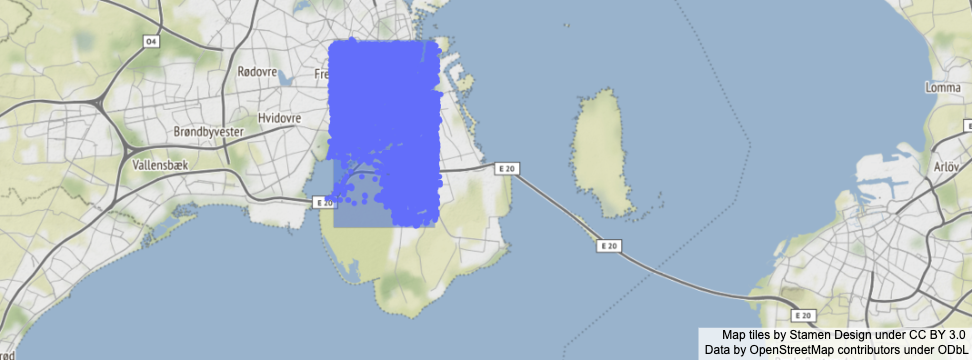

In [188]:
import plotly.express as px


width  = (bbox[2] - bbox[0])
height = (bbox[3] - bbox[1])
bbox_center = (bbox[1] + height/2, bbox[0] + width/2)
bbox_polygon = Polygon([[bbox_center[0] - width/2, bbox_center[1] - height/2],
                        [bbox_center[0] + width/2, bbox_center[1] - height/2],
                        [bbox_center[0] + width/2, bbox_center[1] + height/2],
                        [bbox_center[0] - width/2, bbox_center[1] + height/2],
                        [bbox_center[0] - width/2, bbox_center[1] - height/2]])


print(bbox_center)
fig = px.scatter_mapbox(
    temp_df, lon="x", lat="y", 
    )

fig.update_layout(
    mapbox = {
        'style': "stamen-terrain",
        'center': { 'lon': bbox_center[0], 'lat': bbox_center[1]},
        'zoom': 12, 'layers': [{
            'source': {
                'type': "FeatureCollection",
                'features': [{
                    'type': "Feature",
                    'geometry': {
                        'type': "Polygon",
                        'coordinates': [[
                            [bbox_center[0] - width/2, bbox_center[1] - height/2],
                            [bbox_center[0] + width/2, bbox_center[1] - height/2],
                            [bbox_center[0] + width/2, bbox_center[1] + height/2],
                            [bbox_center[0] - width/2, bbox_center[1] + height/2],
                            [bbox_center[0] - width/2, bbox_center[1] - height/2]
                        ]]
                    }
                }]
            },
            'type': "fill", 'opacity': 0.5, 'below': "traces", 'color': "royalblue"}]},
    margin = {'l':0, 'r':0, 'b':0, 't':0})

In [12]:
temp_df.head(1)

x          y  restaurant_distance  bar_distance  \
id                                                                
118725  12.562906  55.673985               95.097    130.087997   

        school_distance  toilets_distance  college_distance  hospital_distance  
id                                                                              
118725       162.432999        172.011002            1000.0             1000.0

## Find the polygon in geojson where the point is within that polygon

### load the geojson data

In [13]:
import geopandas
import geojson 

filename="dk_polygons_1k"

with open(f'{filename}.json') as f:
    gj = geojson.load(f)

gj_features = gj.features

In [127]:
polygons_df = geopandas.read_file(f'denmark_pop_1k.json')

polygons_df

data                   geometry
0      0.218567  POINT (10.58625 57.75375)
1      0.512380  POINT (10.59458 57.75375)
2      0.716782  POINT (10.60292 57.75375)
3      0.992388  POINT (10.61125 57.75375)
4      0.872486  POINT (10.61958 57.75375)
...         ...                        ...
94672  0.296320  POINT (11.94458 54.56208)
94673  2.932083  POINT (11.95292 54.56208)
94674  1.779469  POINT (11.96125 54.56208)
94675  3.801397  POINT (11.96958 54.56208)
94676  0.425964  POINT (11.97792 54.56208)

[94677 rows x 2 columns]

In [101]:
poly_metadata_df = pd.read_csv(f'{filename}.csv')
poly_metadata_df

Unnamed: 0                                           geometry  \
0               0  POLYGON ((10.58208329189724 57.74958328448848,...   
1               1  POLYGON ((10.59041662519724 57.74958328448848,...   
2               2  POLYGON ((10.59874995849724 57.74958328448848,...   
3               3  POLYGON ((10.60708329179724 57.74958328448848,...   
4               4  POLYGON ((10.61541662509724 57.74958328448848,...   
...           ...                                                ...   
94672       94672  POLYGON ((11.94041661979724 54.55791663058848,...   
94673       94673  POLYGON ((11.94874995309724 54.55791663058848,...   
94674       94674  POLYGON ((11.95708328639724 54.55791663058848,...   
94675       94675  POLYGON ((11.96541661969724 54.55791663058848,...   
94676       94676  POLYGON ((11.97374995299724 54.55791663058848,...   

                                            center  population_density     id  
0      POINT (10.58624995854724 57.75374995113848)            0.218567      0  
1      POINT (10.59458329184724 57.75374995113848)            0.512380      1  
2      POINT (10.60291662514724 57.75374995113848)            0.716782      2  
3      POINT (10.61124995844724 57.75374995113848)            0.992388      3  
4      POINT (10.61958329174724 57.75374995113848)            0.872486      4  
...                                            ...                 ...    ...  
94672  POINT (11.94458328644724 54.56208329723848)            0.296320  94672  
94673  POINT (11.95291661974724 54.56208329723848)            2.932083  94673  
94674  POINT (11.96124995304724 54.56208329723848)            1.779469  94674  
94675  POINT (11.96958328634724 54.56208329723848)            3.801397  94675  
94676  POINT (11.97791661964724 54.56208329723848)            0.425964  94676  

[94677 rows x 5 columns]

In [130]:
polygons_df["polygons"] = poly_metadata_df["geometry"]
polygons_df

data                   geometry  \
0      0.218567  POINT (10.58625 57.75375)   
1      0.512380  POINT (10.59458 57.75375)   
2      0.716782  POINT (10.60292 57.75375)   
3      0.992388  POINT (10.61125 57.75375)   
4      0.872486  POINT (10.61958 57.75375)   
...         ...                        ...   
94672  0.296320  POINT (11.94458 54.56208)   
94673  2.932083  POINT (11.95292 54.56208)   
94674  1.779469  POINT (11.96125 54.56208)   
94675  3.801397  POINT (11.96958 54.56208)   
94676  0.425964  POINT (11.97792 54.56208)   

                                                polygons  
0      POLYGON ((10.58208329189724 57.74958328448848,...  
1      POLYGON ((10.59041662519724 57.74958328448848,...  
2      POLYGON ((10.59874995849724 57.74958328448848,...  
3      POLYGON ((10.60708329179724 57.74958328448848,...  
4      POLYGON ((10.61541662509724 57.74958328448848,...  
...                                                  ...  
94672  POLYGON ((11.94041661979724 54.55791663058848,...  
94673  POLYGON ((11.94874995309724 54.55791663058848,...  
94674  POLYGON ((11.95708328639724 54.55791663058848,...  
94675  POLYGON ((11.96541661969724 54.55791663058848,...  
94676  POLYGON ((11.97374995299724 54.55791663058848,...  

[94677 rows x 3 columns]

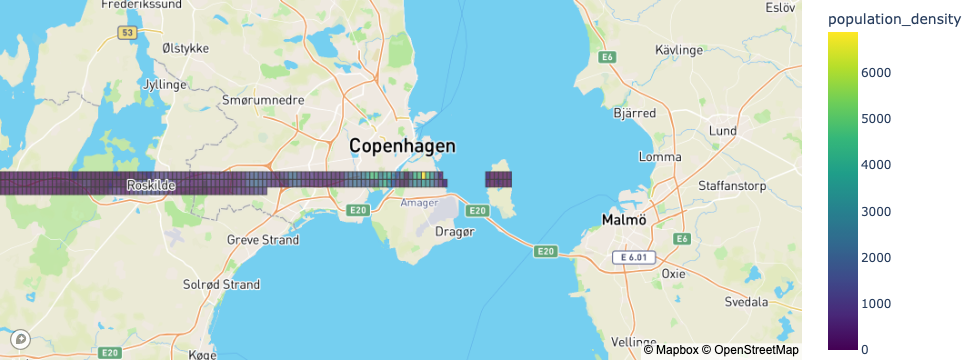

In [206]:
start = 57000
end = start + 1000

gj.features = gj_features[start:end]
px.set_mapbox_access_token(open(".mapbox_token").read())
fig = px.choropleth_mapbox(poly_metadata_df[["population_density", "id"]][start:end], geojson=gj, 
                           locations='id',
                           featureidkey="properties.id",
                           color='population_density',
                           color_continuous_scale="Viridis",
                           #range_color=(0, poly_df["population_density"].head(n).max()),
                           mapbox_style="outdoors",
                           opacity=0.7,
                           center = {"lon":bbox_center[0], "lat": bbox_center[1]}, 
                           zoom = 8.5
                          )
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})


# Display figure
fig.show()

In [131]:
test_df = polygons_df[polygons_df.within(bbox_polygon)] 

test_df["id"] = test_df.index

test_df

/opt/anaconda3/lib/python3.8/site-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



data                   geometry  \
55246   8509.044922  POINT (12.52792 55.69542)   
55247  11358.980469  POINT (12.53625 55.69542)   
55248  12426.899414  POINT (12.54458 55.69542)   
55249  12974.911133  POINT (12.55292 55.69542)   
55250   9767.416016  POINT (12.56125 55.69542)   
...             ...                        ...   
59706    655.886902  POINT (12.57792 55.60375)   
59707    928.264771  POINT (12.58625 55.60375)   
59708    411.116058  POINT (12.59458 55.60375)   
59709    192.624252  POINT (12.60292 55.60375)   
59710    123.196556  POINT (12.61125 55.60375)   

                                                polygons     id  
55246  POLYGON ((12.52374995079724 55.69124995938848,...  55246  
55247  POLYGON ((12.53208328409724 55.69124995938848,...  55247  
55248  POLYGON ((12.54041661739724 55.69124995938848,...  55248  
55249  POLYGON ((12.54874995069724 55.69124995938848,...  55249  
55250  POLYGON ((12.55708328399724 55.69124995938848,...  55250  
...                                                  ...    ...  
59706  POLYGON ((12.57374995059724 55.59958329308848,...  59706  
59707  POLYGON ((12.58208328389724 55.59958329308848,...  59707  
59708  POLYGON ((12.59041661719724 55.59958329308848,...  59708  
59709  POLYGON ((12.59874995049724 55.59958329308848,...  59709  
59710  POLYGON ((12.60708328379724 55.59958329308848,...  59710  

[132 rows x 4 columns]

In [170]:
all_df = pd.DataFrame({})

all_df["lon"] = test_df.geometry.x
all_df["lat"] = test_df.geometry.y
all_df["population_density"] = test_df.data
all_df["cell"] = test_df.polygons
all_df["id"] = test_df.id

all_df["osm_node_count"] = 0

for ame in amenities:
    all_df[f'acc_{ame}_dist'] = 0


all_df

lon        lat  population_density  \
55246  12.527917  55.695417         8509.044922   
55247  12.536250  55.695417        11358.980469   
55248  12.544583  55.695417        12426.899414   
55249  12.552917  55.695417        12974.911133   
55250  12.561250  55.695417         9767.416016   
...          ...        ...                 ...   
59706  12.577917  55.603750          655.886902   
59707  12.586250  55.603750          928.264771   
59708  12.594583  55.603750          411.116058   
59709  12.602917  55.603750          192.624252   
59710  12.611250  55.603750          123.196556   

                                                    cell     id  \
55246  POLYGON ((12.52374995079724 55.69124995938848,...  55246   
55247  POLYGON ((12.53208328409724 55.69124995938848,...  55247   
55248  POLYGON ((12.54041661739724 55.69124995938848,...  55248   
55249  POLYGON ((12.54874995069724 55.69124995938848,...  55249   
55250  POLYGON ((12.55708328399724 55.69124995938848,...  55250   
...                                                  ...    ...   
59706  POLYGON ((12.57374995059724 55.59958329308848,...  59706   
59707  POLYGON ((12.58208328389724 55.59958329308848,...  59707   
59708  POLYGON ((12.59041661719724 55.59958329308848,...  59708   
59709  POLYGON ((12.59874995049724 55.59958329308848,...  59709   
59710  POLYGON ((12.60708328379724 55.59958329308848,...  59710   

       osm_node_count  acc_restaurant_dist  acc_bar_dist  acc_school_dist  \
55246               0                    0             0                0   
55247               0                    0             0                0   
55248               0                    0             0                0   
55249               0                    0             0                0   
55250               0                    0             0                0   
...               ...                  ...           ...              ...   
59706               0                    0             0                0   
59707               0                    0             0                0   
59708               0                    0             0                0   
59709               0                    0             0                0   
59710               0                    0             0                0   

       acc_toilets_dist  acc_college_dist  acc_hospital_dist  
55246                 0                 0                  0  
55247                 0                 0                  0  
55248                 0                 0                  0  
55249                 0                 0                  0  
55250                 0                 0                  0  
...                 ...               ...                ...  
59706                 0                 0                  0  
59707                 0                 0                  0  
59708                 0                 0                  0  
59709                 0                 0                  0  
59710                 0                 0                  0  

[132 rows x 12 columns]

## Fill up new dataframe with data

In [171]:
from shapely.geometry import Point, Polygon
import shapely.wkt

size = len(temp_df)

for i, row in enumerate(temp_df[["x", "y"]].values):
    p = Point(row[0], row[1])

    if i % 10 == 0:
        print(f'{i} of {size}', end='\r')
    
    for tup in all_df[["id","cell"]].values:
        j = tup[0]
        polygon_string = tup[1]
        polygon = shapely.wkt.loads(polygon_string)
        if p.within(polygon):
            row = all_df[all_df.id == j]
            for ame in amenities:
                all_df.at[j,f'acc_{ame}_dist'] = row[f'acc_{ame}_dist'] + temp_df.iloc[i][f'{ame}_distance']
            
            all_df.at[j,'osm_node_count']= row["osm_node_count"] + 1
            break

print()            
print("done")

21100 of 21106
done


In [173]:
for ame in amenities:
    all_df[f'avg_{ame}_dist'] = all_df[f'acc_{ame}_dist']/all_df["osm_node_count"]

In [175]:
all_df[all_df.avg_bar_dist > 0]

lon        lat  population_density  \
55246  12.527917  55.695417         8509.044922   
55247  12.536250  55.695417        11358.980469   
55248  12.544583  55.695417        12426.899414   
55249  12.552917  55.695417        12974.911133   
55250  12.561250  55.695417         9767.416016   
...          ...        ...                 ...   
59706  12.577917  55.603750          655.886902   
59707  12.586250  55.603750          928.264771   
59708  12.594583  55.603750          411.116058   
59709  12.602917  55.603750          192.624252   
59710  12.611250  55.603750          123.196556   

                                                    cell     id  \
55246  POLYGON ((12.52374995079724 55.69124995938848,...  55246   
55247  POLYGON ((12.53208328409724 55.69124995938848,...  55247   
55248  POLYGON ((12.54041661739724 55.69124995938848,...  55248   
55249  POLYGON ((12.54874995069724 55.69124995938848,...  55249   
55250  POLYGON ((12.55708328399724 55.69124995938848,...  55250   
...                                                  ...    ...   
59706  POLYGON ((12.57374995059724 55.59958329308848,...  59706   
59707  POLYGON ((12.58208328389724 55.59958329308848,...  59707   
59708  POLYGON ((12.59041661719724 55.59958329308848,...  59708   
59709  POLYGON ((12.59874995049724 55.59958329308848,...  59709   
59710  POLYGON ((12.60708328379724 55.59958329308848,...  59710   

       osm_node_count  acc_restaurant_dist  acc_bar_dist  acc_school_dist  \
55246              57                47114         52443            57000   
55247              87                46575         51412            78695   
55248              79                14342         14041            39213   
55249              97                15280         21860            73654   
55250             112                24956         24764           111017   
...               ...                  ...           ...              ...   
59706              24                24000         24000            24000   
59707              60                60000         60000            60000   
59708             110               110000        110000           110000   
59709              16                16000         16000            16000   
59710              13                13000         13000            13000   

       acc_toilets_dist  acc_college_dist  acc_hospital_dist  \
55246             53578             57000              46375   
55247             52257             87000              83830   
55248             26967             79000              79000   
55249             38933             97000              97000   
55250             20832            112000             112000   
...                 ...               ...                ...   
59706             24000             24000              24000   
59707             60000             60000              60000   
59708            110000            110000             110000   
59709             16000             16000              16000   
59710             13000             13000              13000   

       avg_restaurant_dist  avg_bar_dist  avg_school_dist  avg_toilets_dist  \
55246           826.561404    920.052632      1000.000000        939.964912   
55247           535.344828    590.942529       904.540230        600.655172   
55248           181.544304    177.734177       496.367089        341.354430   
55249           157.525773    225.360825       759.319588        401.371134   
55250           222.821429    221.107143       991.223214        186.000000   
...                    ...           ...              ...               ...   
59706          1000.000000   1000.000000      1000.000000       1000.000000   
59707          1000.000000   1000.000000      1000.000000       1000.000000   
59708          1000.000000   1000.000000      1000.000000       1000.000000   
59709          1000.000000   1000.000000      1000.000000       1000.000000   
59710          1000.000000   100

In [176]:
all_df

lon        lat  population_density  \
55246  12.527917  55.695417         8509.044922   
55247  12.536250  55.695417        11358.980469   
55248  12.544583  55.695417        12426.899414   
55249  12.552917  55.695417        12974.911133   
55250  12.561250  55.695417         9767.416016   
...          ...        ...                 ...   
59706  12.577917  55.603750          655.886902   
59707  12.586250  55.603750          928.264771   
59708  12.594583  55.603750          411.116058   
59709  12.602917  55.603750          192.624252   
59710  12.611250  55.603750          123.196556   

                                                    cell     id  \
55246  POLYGON ((12.52374995079724 55.69124995938848,...  55246   
55247  POLYGON ((12.53208328409724 55.69124995938848,...  55247   
55248  POLYGON ((12.54041661739724 55.69124995938848,...  55248   
55249  POLYGON ((12.54874995069724 55.69124995938848,...  55249   
55250  POLYGON ((12.55708328399724 55.69124995938848,...  55250   
...                                                  ...    ...   
59706  POLYGON ((12.57374995059724 55.59958329308848,...  59706   
59707  POLYGON ((12.58208328389724 55.59958329308848,...  59707   
59708  POLYGON ((12.59041661719724 55.59958329308848,...  59708   
59709  POLYGON ((12.59874995049724 55.59958329308848,...  59709   
59710  POLYGON ((12.60708328379724 55.59958329308848,...  59710   

       osm_node_count  acc_restaurant_dist  acc_bar_dist  acc_school_dist  \
55246              57                47114         52443            57000   
55247              87                46575         51412            78695   
55248              79                14342         14041            39213   
55249              97                15280         21860            73654   
55250             112                24956         24764           111017   
...               ...                  ...           ...              ...   
59706              24                24000         24000            24000   
59707              60                60000         60000            60000   
59708             110               110000        110000           110000   
59709              16                16000         16000            16000   
59710              13                13000         13000            13000   

       acc_toilets_dist  acc_college_dist  acc_hospital_dist  \
55246             53578             57000              46375   
55247             52257             87000              83830   
55248             26967             79000              79000   
55249             38933             97000              97000   
55250             20832            112000             112000   
...                 ...               ...                ...   
59706             24000             24000              24000   
59707             60000             60000              60000   
59708            110000            110000             110000   
59709             16000             16000              16000   
59710             13000             13000              13000   

       avg_restaurant_dist  avg_bar_dist  avg_school_dist  avg_toilets_dist  \
55246           826.561404    920.052632      1000.000000        939.964912   
55247           535.344828    590.942529       904.540230        600.655172   
55248           181.544304    177.734177       496.367089        341.354430   
55249           157.525773    225.360825       759.319588        401.371134   
55250           222.821429    221.107143       991.223214        186.000000   
...                    ...           ...              ...               ...   
59706          1000.000000   1000.000000      1000.000000       1000.000000   
59707          1000.000000   1000.000000      1000.000000       1000.000000   
59708          1000.000000   1000.000000      1000.000000       1000.000000   
59709          1000.000000   1000.000000      1000.000000       1000.000000   
59710          1000.000000   100

In [185]:
cols = ["lon","lat","population_density"]
cols = cols + [f'avg_{ame}_dist' for ame in amenities]

all_df[cols].to_csv("dk_pop_and_access_1k.csv")

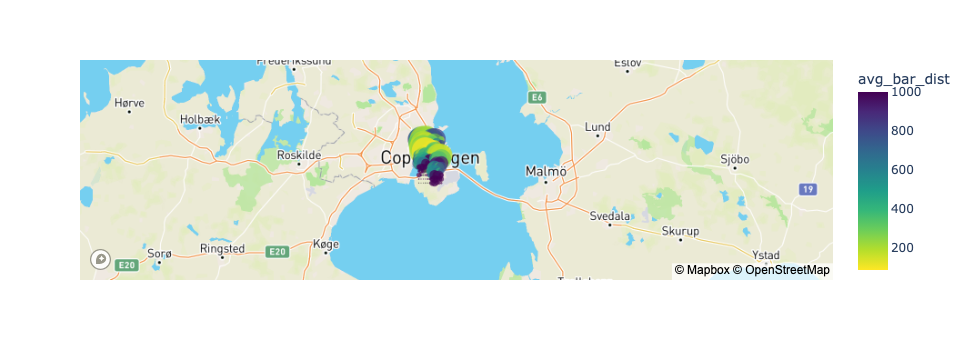

In [249]:
fig = px.scatter_mapbox(
        all_df, lon="lon", lat="lat", 
        hover_data=["population_density"] + [f'avg_{ame}_dist' for ame in amenities],
        size="population_density",
        color='avg_bar_dist',
        color_continuous_scale="Viridis_r", #viridis reversed
        mapbox_style="outdoors",
    )

fig.show()

In [235]:
pois_df = pois[pois["amenity"] == ame][["lon", "lat"]]

pois_df["geometry"] = pois_df.apply(lambda row: Point(row["lon"], row["lat"]), axis=1)


points_gj = geojson.FeatureCollection([geojson.Feature(geometry=geo) for geo in pois_df.geometry]) 

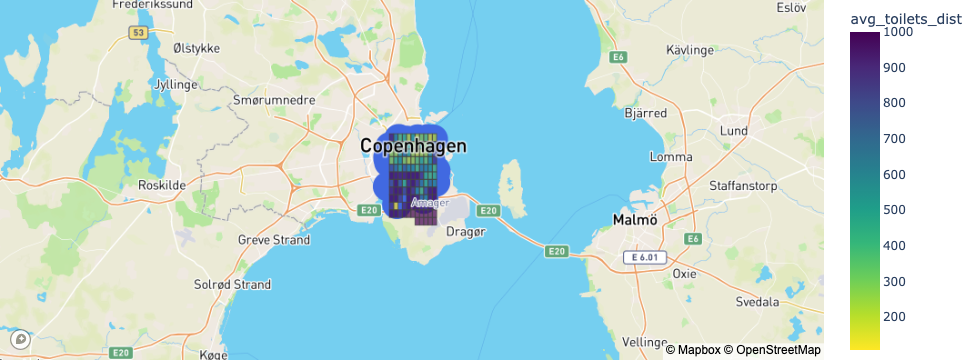

In [248]:

tmp = np.array(gj_features)

tmp = tmp[test_df.index.tolist()]

gj.features = tmp

ame = 'toilets'

pois_df = pois[pois["amenity"] == ame][["lon", "lat"]]

pois_df["geometry"] = pois_df.apply(lambda row: Point(row["lon"], row["lat"]), axis=1)


points_gj = geojson.FeatureCollection([geojson.Feature(geometry=geo) for geo in pois_df.geometry]) 


px.set_mapbox_access_token(open(".mapbox_token").read())
fig = px.choropleth_mapbox(
                            all_df[["population_density", "id"] + [f'avg_{ame}_dist' for ame in amenities]], 
                           geojson=gj, 
                           locations='id',
                           featureidkey="properties.id",
                           #color='population_density',
                            hover_data=["population_density"] + [f'avg_{ame}_dist' for ame in amenities],
                            #size="population_density",
                            color=f'avg_{ame}_dist',
                            color_continuous_scale="Viridis_r", #viridis reversed
                            mapbox_style="outdoors",
                            opacity=0.7,
                           center = {"lon":bbox_center[0], "lat": bbox_center[1]}, 
                           zoom = 8.5
                          )


fig.update_layout(
    mapbox = {
        'layers': [{
            'source': points_gj,
            'type': "circle", 
            'opacity': 1, 
            'below': "traces", 
            'color': "royalblue"
        },
            ]},)
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})


# Display figure
fig.show()

In [220]:
features = ["cell", "population_density", "id"] + [f'avg_{ame}_dist' for ame in amenities]


all_df["cell"] = all_df["cell"].apply(lambda x: shapely.wkt.loads(x))
 
gdf = geopandas.GeoDataFrame(all_df[features], geometry='cell')



gdf.to_file('cph_snippet.geojson', driver="GeoJSON") #.to_json("dk_population_100m.json")

gdf

#with open('cph_snippet.geojson', 'w', encoding='utf8') as fp:
#    geojson.dump(geojson.FeatureCollection(features), gdf, sort_keys=True, ensure_ascii=False)

cell  population_density  \
55246  POLYGON ((12.52375 55.69125, 12.53208 55.69125...         8509.044922   
55247  POLYGON ((12.53208 55.69125, 12.54042 55.69125...        11358.980469   
55248  POLYGON ((12.54042 55.69125, 12.54875 55.69125...        12426.899414   
55249  POLYGON ((12.54875 55.69125, 12.55708 55.69125...        12974.911133   
55250  POLYGON ((12.55708 55.69125, 12.56542 55.69125...         9767.416016   
...                                                  ...                 ...   
59706  POLYGON ((12.57375 55.59958, 12.58208 55.59958...          655.886902   
59707  POLYGON ((12.58208 55.59958, 12.59042 55.59958...          928.264771   
59708  POLYGON ((12.59042 55.59958, 12.59875 55.59958...          411.116058   
59709  POLYGON ((12.59875 55.59958, 12.60708 55.59958...          192.624252   
59710  POLYGON ((12.60708 55.59958, 12.61542 55.59958...          123.196556   

          id  avg_restaurant_dist  avg_bar_dist  avg_school_dist  \
55246  55246           826.561404    920.052632      1000.000000   
55247  55247           535.344828    590.942529       904.540230   
55248  55248           181.544304    177.734177       496.367089   
55249  55249           157.525773    225.360825       759.319588   
55250  55250           222.821429    221.107143       991.223214   
...      ...                  ...           ...              ...   
59706  59706          1000.000000   1000.000000      1000.000000   
59707  59707          1000.000000   1000.000000      1000.000000   
59708  59708          1000.000000   1000.000000      1000.000000   
59709  59709          1000.000000   1000.000000      1000.000000   
59710  59710          1000.000000   1000.000000      1000.000000   

       avg_toilets_dist  avg_college_dist  avg_hospital_dist  
55246        939.964912            1000.0         813.596491  
55247        600.655172            1000.0         963.563218  
55248        341.354430            1000.0        1000.000000  
55249        401.371134            1000.0        1000.000000  
55250        186.000000            1000.0        1000.000000  
...                 ...               ...                ...  
59706       1000.000000            1000.0        1000.000000  
59707       1000.000000            1000.0        1000.000000  
59708       1000.000000            1000.0        1000.000000  
59709       1000.000000            1000.0        1000.000000  
59710       1000.000000            1000.0        1000.000000  

[132 rows x 9 columns]